Loading: data.csv
Raw rows: 541909
After cleaning: 397884 rows, customers: 4338
Snapshot date: 2011-12-10
Saved: rfm_results.csv

Segment summary:
                  customers  avg_recency  avg_frequency  avg_monetary
Segment                                                             
Lost                  1075   216.540465       1.101395    488.500755
Champions              945    12.499471      11.157672   6077.304593
Others                 810   103.483951       1.813580    696.484606
Loyal Customers        764    35.106021       4.180628   1886.314059
New / Potential        311    18.144695       1.244373    442.329389
At Risk                284   135.014085       4.894366   1593.373063
Low Spenders           149    14.765101       2.442953    321.059664


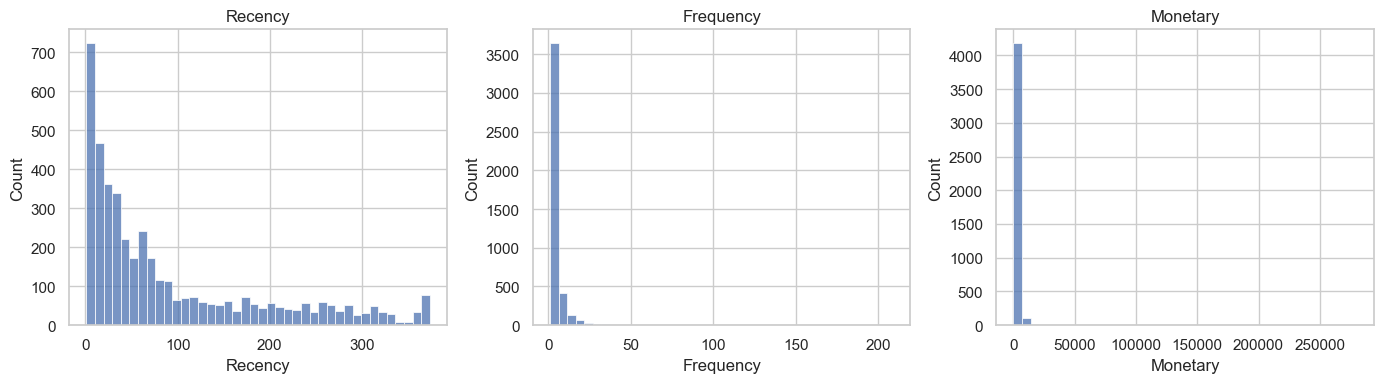

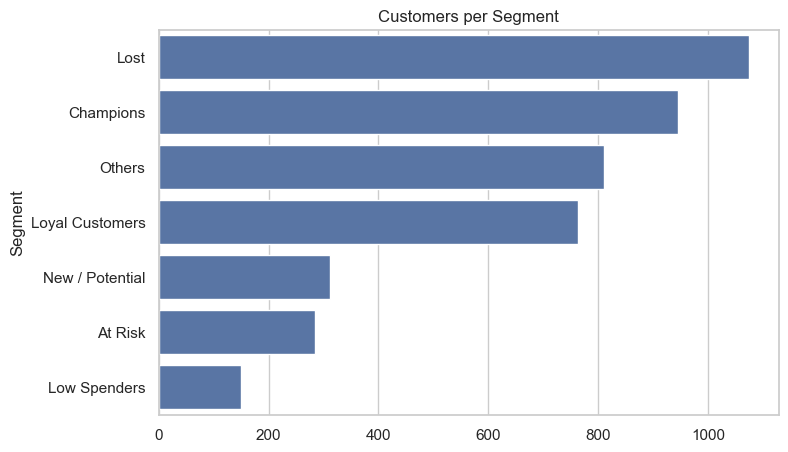


Top Champions:
       CustomerID  Recency  Frequency   Monetary RFM_Score
1689       14646        2         73  280206.02       555
4201       18102        1         60  259657.30       555
3728       17450        8         46  194550.79       555
1879       14911        1        201  143825.06       555
55         12415       24         21  124914.53       455
1333       14156       10         55  117379.63       555
3771       17511        3         31   91062.38       555
3176       16684        4         28   66653.56       555
1289       14096        4         17   65164.79       555
996        13694        4         50   65039.62       555


In [3]:
import os
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def score_series(s: pd.Series, bins: int = 5, reverse: bool = False) -> pd.Series:
    """
    Convert numeric series to integer scores 1..bins (higher = better).
    reverse=True: smaller values are better (Recency).
    Uses qcut on ranks with a safe fallback when qcut fails.
    """
    s = s.fillna(0).astype(float)
    s2 = -s if reverse else s
    try:
        ranks = s2.rank(method="first")
        result = pd.qcut(ranks, q=bins, labels=False) + 1
        return pd.Series(result, index=s.index).astype(int)
    except Exception:
        edges = np.nanpercentile(s2, np.linspace(0, 100, bins + 1))
        for i in range(1, len(edges)):
            if edges[i] <= edges[i - 1]:
                edges[i] = edges[i - 1] + 1e-9
        cutpoints = edges[1:-1]
        binned = np.digitize(s2, cutpoints, right=True) + 1
        return pd.Series(np.clip(binned, 1, bins), index=s.index).astype(int)

def find_column(df: pd.DataFrame, candidates):
    """Find first matching column name (case/space insensitive)."""
    cols_lower = {c.lower().strip(): c for c in df.columns}
    for cand in candidates:
        if cand.lower().strip() in cols_lower:
            return cols_lower[cand.lower().strip()]
    for c in df.columns:
        for cand in candidates:
            if cand.lower() in c.lower():
                return c
    return None

def load_data(path_or_url: str):
    """Load CSV or Excel (local or URL)."""
    if path_or_url.lower().startswith(("http://","https://")):
        r = requests.get(path_or_url, timeout=30)
        r.raise_for_status()
        content = r.content
        ext = os.path.splitext(path_or_url)[1].lower()
        if ext in (".csv",".txt"):
            return pd.read_csv(io.StringIO(content.decode("latin1")))
        else:
            return pd.read_excel(io.BytesIO(content), engine="openpyxl")
    if not os.path.exists(path_or_url):
        raise FileNotFoundError(f"File not found: {path_or_url}")
    ext = os.path.splitext(path_or_url)[1].lower()
    if ext in (".csv",".txt"):
        return pd.read_csv(path_or_url, encoding="latin1")
    elif ext in (".xls",".xlsx"):
        return pd.read_excel(path_or_url, engine="openpyxl")
    else:
        try:
            return pd.read_csv(path_or_url, encoding="latin1")
        except:
            return pd.read_excel(path_or_url, engine="openpyxl")

def compute_rfm(path):
    print("Loading:", path)
    df = load_data(path)
    print("Raw rows:", len(df))

    invoice_col = find_column(df, ["InvoiceNo","Invoice","InvoiceNumber"])
    date_col    = find_column(df, ["InvoiceDate","Date"])
    cust_col    = find_column(df, ["CustomerID","Customer"])
    qty_col     = find_column(df, ["Quantity","Qty"])
    price_col   = find_column(df, ["UnitPrice","Price"])

    missing = [name for name,col in [
        ("InvoiceNo",invoice_col),("InvoiceDate",date_col),
        ("CustomerID",cust_col),("Quantity",qty_col),("UnitPrice",price_col)
    ] if col is None]
    if missing:
        raise KeyError(f"Missing required columns: {missing}\nAvailable: {df.columns.tolist()[:20]}")

    df = df.rename(columns={
        invoice_col:"InvoiceNo", date_col:"InvoiceDate",
        cust_col:"CustomerID", qty_col:"Quantity", price_col:"UnitPrice"
    })

    # clean
    df = df.dropna(subset=["CustomerID"])
    df["CustomerID"] = pd.to_numeric(df["CustomerID"], errors="coerce").dropna().astype(int)
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
    df = df.dropna(subset=["InvoiceDate"])
    df["InvoiceNo"] = df["InvoiceNo"].astype(str)
    df = df[~df["InvoiceNo"].str.startswith(("C","c"))]
    df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
    df["UnitPrice"] = pd.to_numeric(df["UnitPrice"], errors="coerce")
    df = df.dropna(subset=["Quantity","UnitPrice"])
    df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
    print("After cleaning:", len(df), "rows, customers:", df["CustomerID"].nunique())

    df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

    snapshot = df["InvoiceDate"].max() + pd.Timedelta(days=1)
    print("Snapshot date:", snapshot.date())

    rfm = df.groupby("CustomerID").agg(
        LastPurchase=("InvoiceDate","max"),
        Frequency=("InvoiceNo", pd.Series.nunique),
        Monetary=("TotalPrice","sum")
    ).reset_index()
    rfm["Recency"] = (snapshot - rfm["LastPurchase"]).dt.days

    rfm["R_Score"] = score_series(rfm["Recency"], bins=5, reverse=True)
    rfm["F_Score"] = score_series(rfm["Frequency"], bins=5, reverse=False)
    rfm["M_Score"] = score_series(rfm["Monetary"], bins=5, reverse=False)
    rfm["RFM_Score"] = rfm["R_Score"].astype(str)+rfm["F_Score"].astype(str)+rfm["M_Score"].astype(str)

    def seg(row):
        if row["R_Score"]>=4 and row["F_Score"]>=4 and row["M_Score"]>=4: return "Champions"
        if row["R_Score"]>=3 and row["F_Score"]>=3 and row["M_Score"]>=3: return "Loyal Customers"
        if row["R_Score"]>=4 and row["F_Score"]<=2: return "New / Potential"
        if row["R_Score"]>=4 and row["M_Score"]<=2: return "Low Spenders"
        if row["R_Score"]<=2 and row["F_Score"]>=4: return "At Risk"
        if row["R_Score"]<=2 and row["F_Score"]<=2: return "Lost"
        return "Others"
    rfm["Segment"] = rfm.apply(seg, axis=1)

    
    out_file = "rfm_results.csv"
    rfm.to_csv(out_file, index=False)
    print("Saved:", out_file)

    summary = rfm.groupby("Segment").agg(
        customers=("CustomerID","nunique"),
        avg_recency=("Recency","mean"),
        avg_frequency=("Frequency","mean"),
        avg_monetary=("Monetary","mean")
    ).sort_values("customers", ascending=False)
    print("\nSegment summary:\n", summary)

    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1); sns.histplot(rfm["Recency"], bins=40); plt.title("Recency")
    plt.subplot(1,3,2); sns.histplot(rfm["Frequency"], bins=40); plt.title("Frequency")
    plt.subplot(1,3,3); sns.histplot(rfm["Monetary"], bins=40); plt.title("Monetary")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,5))
    order = rfm["Segment"].value_counts().index
    sns.barplot(x=rfm["Segment"].value_counts().values, y=order)
    plt.title("Customers per Segment"); plt.show()

    return rfm

if __name__ == "__main__":
   
    path = "data.csv"
    rfm_table = compute_rfm(path)
    print("\nTop Champions:\n", 
          rfm_table[rfm_table["Segment"]=="Champions"]
          .sort_values("Monetary", ascending=False)
          .head(10)[["CustomerID","Recency","Frequency","Monetary","RFM_Score"]])